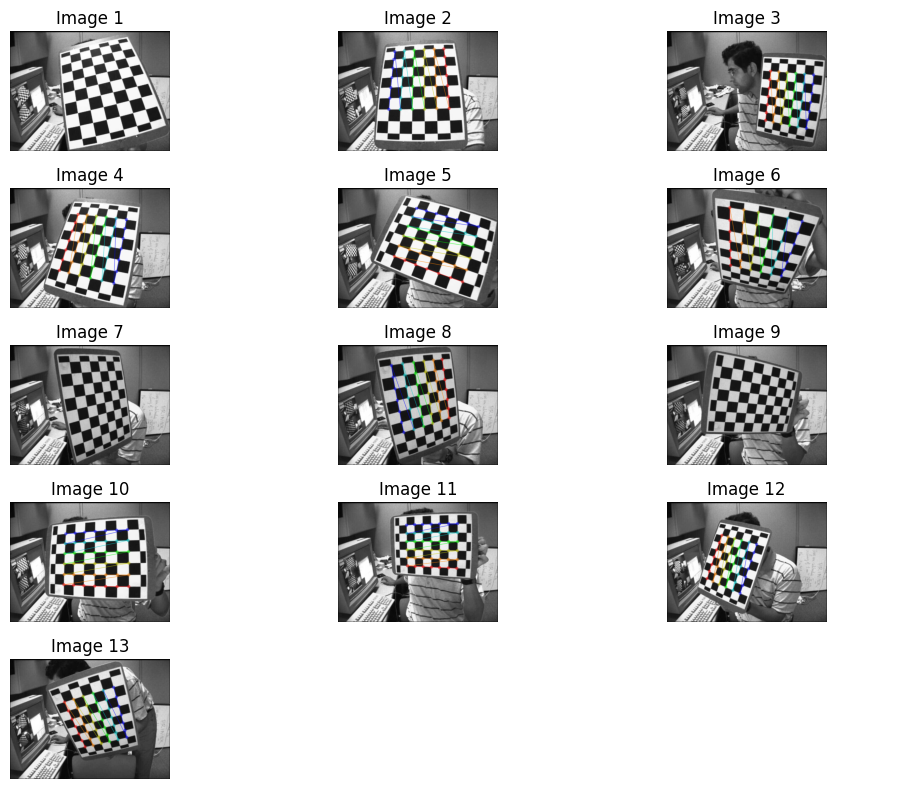

In [ ]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

# Khởi tạo tiêu chí tạm dừng: Dừng nếu sai số nhỏ hơn giá trị 0.001 và nếu số vòng lặp đạt tối đa 30 lần
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Các điểm 3D
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)#Lưới tạo ma trận

# Khởi tạo danh sách lưu trữ
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('*.jpg')
# Tạo một figure để chứa tất cả các hình ảnh
fig, axes = plt.subplots(5, 3, figsize=(10,8))
for i,  fname in enumerate(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Tìm góc trên bàn cờ vua
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)

    if ret == True:
        objpoints.append(objp)
        #Tinh chỉnh tọa độ góc
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Vẽ các góc trên ảnh
        cv.drawChessboardCorners(img, (7,6), corners2, ret)

    # Chuyển đổi ảnh từ BGR sang RGB trước khi hiển thị với matplotlib
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Hiển thị ảnh trong subplot tương ứng
    ax = axes.flatten()[i]  # Lấy subplot tương ứng
    ax.imshow(img_rgb)
    ax.axis('off')  # Tắt trục tọa độ
    ax.set_title(f'Image {i+1}')  # Tiêu đề cho mỗi ảnh

# Nếu có nhiều subplot hơn số lượng ảnh, ẩn các subplot không sử dụng
for j in range(len(images), len(axes.flatten())):
    axes.flatten()[j].axis('off')
# Hiển thị tất cả các hình ảnh
plt.tight_layout()
plt.show()

In [ ]:
#Tính toán ma trạn camera, hế  số méo, vector xoay, ...
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# Kết quả trả về:
# - ret: giá trị lỗi tái chiếu, thể hiện độ chính xác của hiệu chỉnh.
# - mtx: ma trận nội tại
# - dist: hệ số biến dạng
# - rvecs: mỗi ảnh có một vector quay, biểu diễn hướng của camera trong không gian
# - tvecs: mô tả vị trí của camera so với hệ tọa độ 3D của bàn cờ

In [ ]:
img = cv.imread('left12.jpg')
h,  w = img.shape[:2]
#Tính toán ma trận mới tối ưu
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
#roi là vùng ảnh hợp lý của bức ảnh sau khi hiệu chỉnh, nó cho biết phần vùng ảnh hợp lý mà bạn nên giữ lại sau khi áp dụng ma trận camera mới, tránh việc cắt mất các phần quan trọng của ảnh


In [ ]:
# Loại bỏ biến dạng
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('calibresult.png', dst)

True

In [ ]:
# undistort
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('calibresult.png', dst)


True

<Figure size 2000x1000 with 0 Axes>

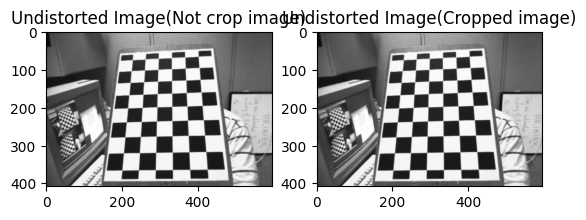

In [ ]:
image = cv.imread('calibresult.png')
plt.figure(figsize=(20, 10))
plt.subplots(1, 2)
plt.subplot(121), plt.imshow(dst), plt.title("Undistorted Image(Not crop image)")
plt.subplot(122), plt.imshow(image), plt.title("Undistorted Image(Cropped image)")
plt.show()

In [ ]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.023970527483646937
